In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Flatten

from transformer.encoder import Encoder

In [2]:
config = {'num_heads': 12, 
          'vocab_size': 30522,
          'hidden_size': 128,
          'max_position_embeds': 512,
          'intermediate_size': 512,
          'dropout_p': 0.1,
          'input_size': (100,),
          'num_hidden_layers': 1}

## Get some toy data

The yelp sentence sentiment data set from Kaggle will do

In [3]:
rows = []
with open('yelp_labelled.txt', 'r') as FILE:
    while True:
        row = FILE.readline()
        if not row:
            break
        row = row.strip().split('\t')
        sentence = row[0]
        sentiment = int(row[1])
        rows.append({'sentence': sentence, 'sentiment': sentiment})
 
df = pd.DataFrame(rows, columns=['sentence', 'sentiment'])
df.head()

,sentence,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Get our toy vocabulary

In [4]:
vocab = {'<pad>': 0, '<unk>': 1}
index = 2
for s in df['sentence'].values:
    words = s.strip().split()
    for word in words:
        i = vocab.get(word)
        if i is None:
            vocab[word] = index
            index += 1

vocab_reverse = {value: key for key, value in vocab.items()}

config['vocab_size'] = len(vocab)


### Tokenize the sentences and split into x and y 

y will be the last token of each sequence, so we can try to predict it. But mostly we just want to see if our transformer encoder trains.

In [5]:
def tokenize(sent):
    tokens = [vocab[word] for word in sent.strip().split()]
    return tokens

tokens = list(map(tokenize, df['sentence']))
x = [s[:-1] for s in tokens]
x = tf.keras.utils.pad_sequences(x)
y = np.array([s[-1] for s in tokens])

config['input_size'] = (len(x[0]),)

print(f'Number of sentences: {df.shape[0]}')
print(f'Vocabulary size: {config["vocab_size"]}')
print(f'Max sentence length: {config["input_size"][0]}')

Number of sentences: 1000
Vocabulary size: 2971
Max sentence length: 31


## Try our transformer!

We'll just train our encoder by the task of predicting the last word of each sentence

In [10]:
clf = Sequential([InputLayer(input_shape=config['input_size']),
                  Encoder(config),
                  Flatten(),
                  Dense(config['vocab_size'], activation='softmax')])

clf.build()
clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Encoder)           (None, 31, 128)           640232    
                                                                 
 flatten_1 (Flatten)         (None, 3968)              0         
                                                                 
 dense_79 (Dense)            (None, 2971)              11791899  
                                                                 
Total params: 12,432,131
Trainable params: 12,432,131
Non-trainable params: 0
_________________________________________________________________


In [11]:
clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
hist = clf.fit(x, 
               y,
               epochs=100)

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 8.2285
Epoch 2/100
1/1 [==============================] - 0s 171ms/step - loss: 5.5267
Epoch 3/100
1/1 [==============================] - 0s 168ms/step - loss: 3.1373
Epoch 4/100
1/1 [==============================] - 0s 177ms/step - loss: 2.0923
Epoch 5/100
1/1 [==============================] - 0s 174ms/step - loss: 1.6222
Epoch 6/100
1/1 [==============================] - 0s 186ms/step - loss: 1.6809
Epoch 7/100
1/1 [==============================] - 0s 190ms/step - loss: 1.6765
Epoch 8/100
1/1 [==============================] - 0s 183ms/step - loss: 1.7424
Epoch 9/100
1/1 [==============================] - 0s 191ms/step - loss: 1.4399
Epoch 10/100
1/1 [==============================] - 0s 206ms/step - loss: 1.2642
Epoch 11/100
1/1 [==============================] - 0s 189ms/step - loss: 1.3231
Epoch 12/100
1/1 [==============================] - 0s 181ms/step - loss: 1.3622
Epoch 13/100
1/1 [====================

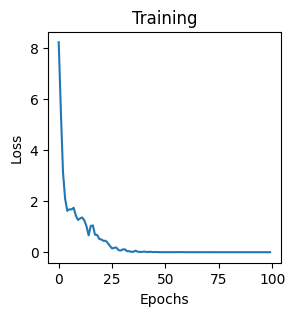

In [12]:
plt.figure(figsize=(3,3))
plt.plot(hist.history['loss'])
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


## Test our toy model

Make up a few sentences that may belong to the distribution (Yelp restaraunt review sentences).

Then, dropping off that last word of each, try to complete them. 


In [13]:
s = ["It really tasted awful.",
     "It was very good.",
     "It was awful.",
     "This is a very bad place.",
     "The spaghetti was perfect",
     "The eggs were gross!",
     "My steak was bad."]

# Tokenize our sentence, separate last word, and pad
tokens = list(map(tokenize, s))
x = [s[:-1] for s in tokens]
x = tf.keras.utils.pad_sequences(x, maxlen=config['input_size'][0])
y = np.array([s[-1] for s in tokens])

# Predict last word
y_hat = clf.predict(x)
y_hat = np.argmax(y_hat, axis=1)

for i in range(len(s)):
     # construct predicted complete sentence
     pred_s = x[i].tolist()
     pred_s.append(y_hat[i])

     #unpad
     pred_s = [token for token in pred_s if token!= 0]
     pred_s = ' '.join([vocab_reverse[i] for i in pred_s])
     print(f'\nOriginal sentence: {s[i]}\nCompleted sentence: {pred_s}')




1/1 [==============================] - 2s 2s/step

Original sentence: It really tasted awful.
Completed sentence: It really tasted awful.

Original sentence: It was very good.
Completed sentence: It was very good.

Original sentence: It was awful.
Completed sentence: It was awful.

Original sentence: This is a very bad place.
Completed sentence: This is a very bad place.

Original sentence: The spaghetti was perfect
Completed sentence: The spaghetti was perfect

Original sentence: The eggs were gross!
Completed sentence: The eggs were gross!

Original sentence: My steak was bad.
Completed sentence: My steak was bad.
